### INSTALACION DE LOS PAQUETES NECESARIOS

In [2]:
! pip install -U spacy
! python -m spacy download en
! pip install spacy
! pip install spacymoji
! pip install emoji
! pip install scikit-learn
! pip install gensim
! pip install sklearn
! pip install matplotlib
! pip install pandas

  Using cached spacy-3.7.2-cp310-cp310-win_amd64.whl (12.1 MB)
  Using cached smart_open-6.4.0-py3-none-any.whl (57 kB)
  Using cached wasabi-1.1.2-py3-none-any.whl (27 kB)
  Using cached typer-0.9.0-py3-none-any.whl (45 kB)
  Using cached pydantic-2.4.2-py3-none-any.whl (395 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached srsly-2.4.8-cp310-cp310-win_amd64.whl (481 kB)
  Using cached murmurhash-1.0.10-cp310-cp310-win_amd64.whl (25 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl (22 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached cymem-2.0.8-cp310-cp310-win_amd64.whl (39 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached thinc-8.2.1-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
  Using cached weasel-0.3.3-py3-none-any.whl (49 kB)
  Using cached preshed-3.0.9-cp310-cp310-win_amd64.whl (122 kB)
  Using cached pydantic_core-2.10.1-cp310-none-win_amd64.whl


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     --------------------------------------- 12.8/12.8 MB 22.6 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached spacymoji-3.1.0-py2.py3-none-any.whl (8.5 kB)
  Using cached emoji-2.8.0-py2.py3-none-any.whl (358 kB)



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached gensim-4.3.2-cp310-cp310-win_amd64.whl (24.0 MB)



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post10-py3-none-any.whl



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import spacy
import emoji
import numpy as np
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

# 1. Preparación del Dataset

## 1.1. CARGAR FICHERO CSV CON LOS DATOS

In [176]:
datsetPath = './Datasets/corto.csv'
#datsetPath = '../Datasets/SuicideDetection.csv'

data = pd.read_csv(datsetPath)

data.info()
data.head(len(data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  76 non-null     int64 
 1   text        76 non-null     object
 2   class       76 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
71,107,Anyone planning suicide in the long-term futur...,suicide
72,108,What the fuck?? I finally had the confidence t...,non-suicide
73,110,Screenwriting Course Scripts and Characters th...,suicide
74,111,The reviews on the dildo said weak suction cup...,non-suicide


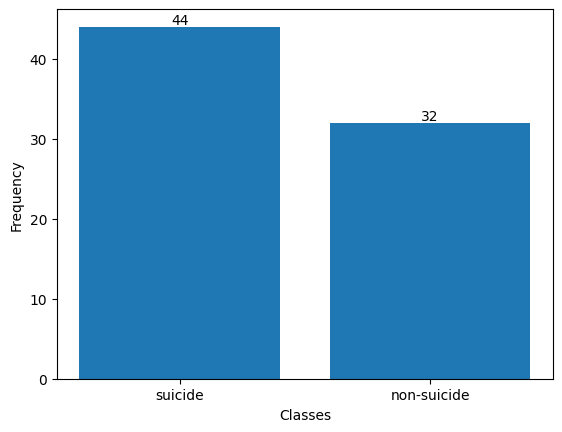

In [9]:
from matplotlib import pyplot as plt

barPlot = plt.bar(data['class'].value_counts().index, data['class'].value_counts())
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.bar_label(barPlot)
plt.show()

## 1.2. SELECCIONAR LA COLUMNA DE TEXTOS (DISCRIMINAR LA CLASE)

In [10]:
textos = []
for instancia in data.values:
    textos.append(instancia[1])

# 2. Pre-proceso
## 2.1. LIMPIEZA Y FORMARTEO DE LOS DATOS

In [11]:
# Cuidado! La ejecución de este bloque con 232074 instancias, toma aproximademente 5 min? 

nlp = spacy.load("en_core_web_sm") # Cargar modelo
nlp.add_pipe("emoji", first=True)

textos_tokenizados = []
for texto in tqdm(textos, desc="Procesando textos"):
    texto = emoji.demojize(texto)  # Emojis a texto
    doc = nlp(texto)
    lexical_tokens = [token.lemma_.lower() for token in doc if len(token.text) > 3 and token.is_alpha]
    textos_tokenizados.append(lexical_tokens)

Procesando textos: 100%|██████████| 76/76 [00:03<00:00, 22.62it/s]


In [12]:
print(textos[0])
print(textos_tokenizados[0])

Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.
['wife', 'threaten', 'suiciderecently', 'leave', 'wife', 'good', 'because', 'cheat', 'twice', 'lie', 'much', 'that', 'have', 'decide', 'refuse', 'back', 'day', 'begin', 'threaten', 'suicide', 'have', 'tirelessly', 'spend', 'these', 'paat', 'day', 'talk', 'keep', 'hesitate', 'because'

## 2.2. Espacio de decisión - VECTORIZACION DE LOS DATOS (DOC2VEC)

In [13]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(textos_tokenizados)]
model = Doc2Vec(documents, vector_size=150, window=2, dm=1, epochs=100, workers=4)
# DM siempre a 1 para que sea distributed memory (que tenga en cuenta el contexto)
# Window se puede cambiar pero tener en cuenta que cuanto mayor sea mas coste genera
# Negative: siempre a 0 para que aprenda que palabras son ruido
#Los que se pueden probar para parametro ekorketa:
    # VECTOR SIZE!!!! (tamaño del embedding: dimensiones)
    # Epochs: numero de iteraciones por el dataset
    # Alpha: learning rate inicial
    # Min alpha: El valor de LR con el que va acabar → Igual no poner?
    # Max_vocab_size: Limita el tamaño maximo de las palabras a tener en cuenta (borra las menos frecuentes)

model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

model.save(get_tmpfile("my_doc2vec_model"))

#vector = model.infer_vector(['wife', 'threaten', 'leave', 'wife', 'good', 'because', 'cheat', 'twice', 'lie', 'much', 'that', 'have', 'decide', 'refuse', 'back', 'day', 'begin', 'threaten', 'suicide', 'have', 'tirelessly', 'spend', 'these', 'paat', 'day', 'talk', 'keep'])

#similar_documents = model.dv.most_similar(vector) # Deberia salir 0 porque es el documento del que se han sacado todas las palabras

# 3. Clustering

## 3.1. Aplicando algoritmo DBSCAN (PREDETERMINADO) de la libería sklearn

In [207]:
epsilon = 4  # Radio de búsqueda
min_pts = 2  # Número mínimo de puntos en un cluster

In [208]:
document_vectors = [model.infer_vector(doc) for doc in textos_tokenizados]
# Aplicar DBSCAN a los vectores de documentos
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts, leaf_size=5)  # Ajusta los parámetros según tu caso
dbscan_labels = dbscan.fit_predict(np.array(document_vectors))

# Los resultados del clustering están en 'labels'
print("Etiquetas de clusters:", dbscan_labels)


Etiquetas de clusters: [-1  0  0  0 -1 -1 -1  0 -1 -1  0  0  0  0  0  0 -1  0  0  0 -1  0 -1 -1
 -1  0 -1 -1  0  0  0 -1  0 -1  0  0 -1 -1 -1  0  0  0 -1  0 -1  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1  0 -1  0 -1
 -1 -1  0  0]


In [209]:
kont = np.sum(dbscan_labels== -1)
print("Clasificadas como ruido: ",kont)
print("Clasificadas como cluster: ",np.sum(dbscan_labels!=-1))

Clasificadas como ruido:  29
Clasificadas como cluster:  47


In [210]:
sample_cores=np.zeros_like(dbscan_labels,dtype=bool)
sample_cores[dbscan.core_sample_indices_]=True
n_clusters=len(set(dbscan_labels))- (1 if -1 in dbscan_labels else 0)
print('Numero de clusters:',n_clusters)

Numero de clusters: 1


RESULTADOS 2D

In [217]:
from sklearn.decomposition import PCA
print('Dim originally: ',np.array(document_vectors).shape)
pca = PCA(n_components=2,random_state=42)
pca.fit(document_vectors)
datos_reducidos_dbscan = pca.transform(document_vectors)
print('Dim after PCA: ',datos_reducidos_dbscan.shape)


Dim originally:  (76, 150)
Dim after PCA:  (76, 2)


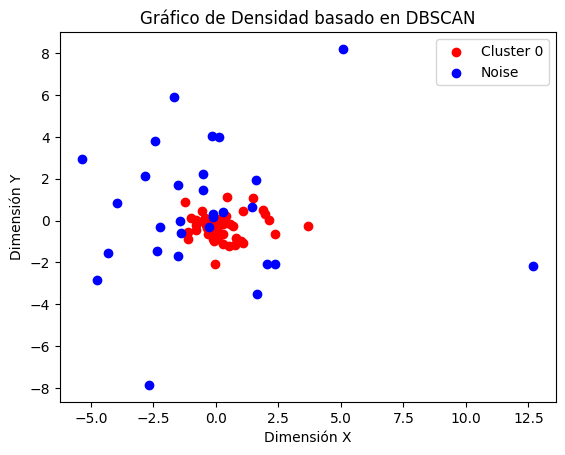

In [218]:
unique_labels = set(dbscan_labels) - {-1}
for label in unique_labels:
    cluster_points = np.array([datos_reducidos_dbscan[i] for i in range(len(datos_reducidos_dbscan)) if dbscan_labels[i] == label])
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c='red', label=f'Cluster {label}')

noise_points = np.array([datos_reducidos_dbscan[i] for i in range(len(datos_reducidos_dbscan)) if dbscan_labels[i] == -1])
plt.scatter(noise_points[:, 0], noise_points[:, 1], c='blue', label='Noise')

plt.title('Gráfico de Densidad basado en DBSCAN')
plt.xlabel('Dimensión X')
plt.ylabel('Dimensión Y')
plt.legend()
plt.show()

RESULTADOS 3D

In [225]:
from sklearn.decomposition import PCA
print('Dim originally: ',np.array(document_vectors).shape)
pca = PCA(n_components=3,random_state=42)
pca.fit(document_vectors)
datos_reducidos_dbscan = pca.transform(document_vectors)
print('Dim after PCA: ',datos_reducidos_dbscan.shape)

Dim originally:  (76, 150)
Dim after PCA:  (76, 3)


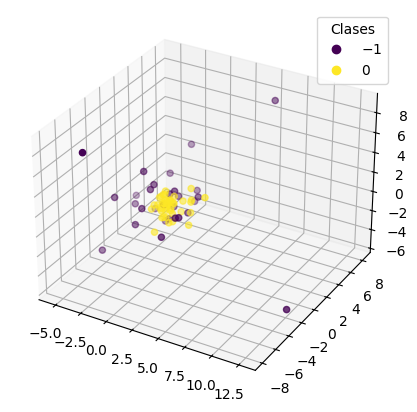

In [226]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(datos_reducidos_dbscan[:, 0], datos_reducidos_dbscan[:, 1], datos_reducidos_dbscan[:, 2], cmap='viridis', c=dbscan_labels[:])
plt.legend(*sc.legend_elements(), title="Clases")
# Mostrar la gráfica en 3D
plt.show()

NUESTRO DBSCAN

In [213]:

def dbscan(data, epsilon, min_pts):
    clusters = []
    noise_points = set()
    visited = set()

    def get_neighbors(point):
        neighbors = []
        # i = indice de cada dato
        # d = vetor de cada dato
        for i,d in enumerate(data):
            if distance(point, d) <= epsilon:
                neighbors.append(i)
        return neighbors

    def expand_cluster(labels, i, neighbors, cluster_id):
        labels[i]=cluster_id
        i=0
        while i< len(neighbors):
            neighbor=neighbors[i]
            if labels[neighbor] == -1:
                labels[neighbor] = cluster_id
            elif labels[neighbor] == 0:
                labels[neighbor] = cluster_id
                new_neighbors = get_neighbors(data[neighbor])
                if len(new_neighbors) >= min_pts:
                    neighbors = neighbors + new_neighbors
            i += 1

    labels=[0]*len(data)
    cluster_id=0
    for i in range(len(data)):
        if labels[i]==0:
            neighbors=get_neighbors(data[i])
            if len(neighbors)<min_pts:
                labels[i]=-1
            else:
                cluster_id=cluster_id+1
                expand_cluster(labels, i, neighbors, cluster_id)
    return labels

# Distancia euclidea
def distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

# Convertir los datos a una lista de tuplas

cluster_labels = dbscan(np.array(document_vectors), epsilon, min_pts)
print(cluster_labels)


[-1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1]


In [214]:
print("Clasificadas como ruido: ",cluster_labels.count(-1))
print("Clasificadas como cluster: ",len(cluster_labels)-cluster_labels.count(-1))

Clasificadas como ruido:  29
Clasificadas como cluster:  47


In [179]:
#Cambiamos los cluster=1 por cluster=0
cluster_labels_nueva = [0 if x == 1 else x for x in cluster_labels]

if set(dbscan_labels)==set(cluster_labels_nueva):
    print("SON IGUALES")
else:
    print("NO SON IGUALES")


SON IGUALES


RESULTADOS 2D

In [180]:
from sklearn.decomposition import PCA
print('Dim originally: ',np.array(document_vectors).shape)
pca = PCA(n_components=2,random_state=42)
pca.fit(document_vectors)
datos_reducidos_nuestro = pca.transform(document_vectors)
print('Dim after PCA: ',datos_reducidos_nuestro.shape)

Dim originally:  (76, 150)
Dim after PCA:  (76, 2)


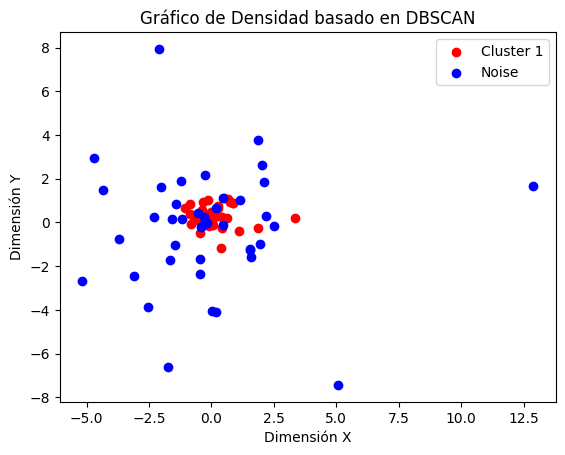

In [181]:
unique_labels = set(cluster_labels) - {-1}

for label in unique_labels:
    cluster_points = np.array([datos_reducidos_nuestro[i] for i in range(len(datos_reducidos_nuestro)) if cluster_labels[i] == label])
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c='red', label=f'Cluster {label}')


noise_points = np.array([datos_reducidos_nuestro[i] for i in range(len(datos_reducidos_nuestro)) if cluster_labels[i] == -1])
plt.scatter(noise_points[:, 0], noise_points[:, 1], c='blue', label='Noise')

plt.title('Gráfico de Densidad basado en DBSCAN')
plt.xlabel('Dimensión X')
plt.ylabel('Dimensión Y')
plt.legend()
plt.show()


RESULTADOS 3D

In [220]:
from sklearn.decomposition import PCA
print('Dim originally: ',np.array(document_vectors).shape)
pca = PCA(n_components=3,random_state=42)
pca.fit(document_vectors)
datos_reducidos_nuestro = pca.transform(document_vectors)
print('Dim after PCA: ',datos_reducidos_nuestro.shape)

Dim originally:  (76, 150)
Dim after PCA:  (76, 3)


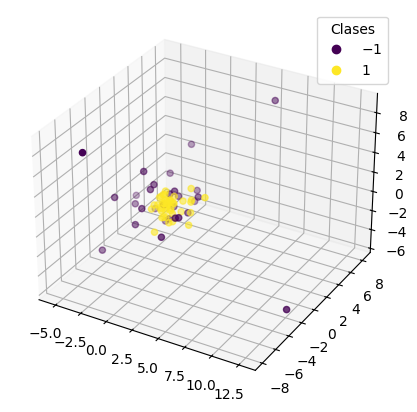

In [223]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(datos_reducidos_nuestro[:, 0], datos_reducidos_nuestro[:, 1], datos_reducidos_nuestro[:, 2], cmap='viridis', c=cluster_labels[:])
plt.legend(*sc.legend_elements(), title="Clases")
# Mostrar la gráfica en 3D
plt.show()